In [77]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Conditional VAE for genetic circuits

This notebook follows the previous VAE notebook very closely, but implementing a conditional VAE instead. Loosely following [this blog post](https://agustinus.kristia.de/techblog/2016/12/17/conditional-vae/).

## Imports 

In [78]:
# %env XLA_PYTHON_CLIENT_ALLOCATOR=platform

from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.data.data_format_tools.common import write_json
from synbio_morpher.utils.misc.string_handling import prettify_keys_for_label
from functools import partial

from sklearn.metrics import r2_score  
import os
import sys
import numpy as np
import haiku as hk
import jax
import optax

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
                
import wandb

from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'gpu')


# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)


jax.devices()

[gpu(id=0)]

In [99]:
from src.models.vae import CVAE, sample_z
from src.models.mlp import MLP
from src.models.shared import arrayise
from src.losses.losses import loss_wrapper, compute_accuracy_regression, mse_loss, accuracy_regression
from src.utils.data_preprocessing import drop_duplicates_keep_first_n
from src.utils.optimiser import make_optimiser
from src.utils.train import make_saves

## Load data

In [80]:
fn = '../data/processed/ensemble_mutation_effect_analysis/2023_07_17_105328/tabulated_mutation_info.csv'
fn_test_data = '../data/raw/ensemble_mutation_effect_analysis/2023_10_03_204819/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
try:
    data.drop(columns=['Unnamed: 0'], inplace=True)
except:
    pass

## Hyperparameters

In [81]:
# Architecture
HIDDEN_SIZE = 32
NUM_ENC_LAYERS = 3
NUM_DEC_LAYERS = 3


BATCH_SIZE = 128
N_BATCHES = 1200
TOTAL_DS = BATCH_SIZE * N_BATCHES
MAX_TOTAL_DS = TOTAL_DS
TRAIN_SPLIT = 0.8
SCALE_X = False
LEARNING_RATE = 5e-4
LEARNING_RATE_SCHED = 'cosine_decay'
# LEARNING_RATE_SCHED = 'constant'
WARMUP_EPOCHS = 20
L2_REG_ALPHA = 0.01
EPOCHS = 1000
PRINT_EVERY = EPOCHS // 100
SEED = 1

INPUT_SPECIES = 'RNA_1'
USE_CATEGORICAL = False
target_circ_func = 'sensitivity_wrt_species-6'
input_concat_diffs = False
input_concat_axis = 0

# Training
USE_DROPOUT = False
USE_L2_REG = False
USE_WARMUP = True

loss_fn = partial(
    loss_wrapper, loss_f=mse_loss, use_l2_reg=USE_L2_REG) 
compute_accuracy = compute_accuracy_regression

subtask = '_test'
save_path = str(datetime.now()).split(' ')[0].replace(
    '-', '_') + '__' + str(datetime.now()).split(' ')[-1].split('.')[0].replace(':', '_') + '_saves' + subtask
save_path = os.path.join('weight_saves', '10_cvae', save_path)

rng = jax.random.PRNGKey(SEED)

# Initialise

## Init data

In [82]:
filt = data['sample_name'] == INPUT_SPECIES

# Balance the dataset
df = drop_duplicates_keep_first_n(data[filt], get_true_interaction_cols(
    data, 'energies', remove_symmetrical=True), n=100)

TOTAL_DS = np.min([TOTAL_DS, MAX_TOTAL_DS, len(df)])
N_BATCHES = TOTAL_DS // BATCH_SIZE
TOTAL_DS = N_BATCHES * BATCH_SIZE

x_cols = [get_true_interaction_cols(data, 'energies', remove_symmetrical=True)]
if input_concat_diffs:
    k = 'energies'
    x_cols = x_cols + \
        [[f'{i}_diffs' for i in get_true_interaction_cols(
            data, k, remove_symmetrical=True)]]

x = [df[i].iloc[:TOTAL_DS].values[:, :, None] for i in x_cols]
x = np.concatenate(x, axis=input_concat_axis+1).squeeze()

if SCALE_X:
    xscaler = MinMaxScaler()
    x = xscaler.fit_transform(x)

In [83]:
cond = df[target_circ_func].iloc[:TOTAL_DS].to_numpy()

if USE_CATEGORICAL:
    from src.utils.math import convert_to_scientific_exponent

    vectorized_convert_to_scientific_exponent = np.vectorize(
        convert_to_scientific_exponent)
    numerical_resolution = 2
    cond_map = {k: numerical_resolution for k in np.arange(int(f'{cond[cond != 0].min():.0e}'.split(
        'e')[1])-1, np.max([int(f'{cond.max():.0e}'.split('e')[1])+1, 0 + 1]))}
    cond_map[-6] = 1
    cond_map[-5] = 1
    cond_map[-4] = 4
    cond_map[-3] = 2
    cond_map[-1] = 3
    cond = jax.tree_util.tree_map(partial(
        vectorized_convert_to_scientific_exponent, numerical_resolution=cond_map), cond)
    cond = np.interp(cond, sorted(np.unique(cond)), np.arange(
        len(sorted(np.unique(cond))))).astype(int)
else:
    zero_log_replacement = -10.0
    cond = np.where(cond != 0, np.log10(cond), zero_log_replacement)

cond = cond[:, None]
N_HEAD = x.shape[-1]

x, cond = shuffle(x, cond, random_state=SEED)

if x.shape[0] < TOTAL_DS:
    print(
        f'WARNING: The filtered data is not as large as the requested total dataset size: {x.shape[0]} vs. requested {TOTAL_DS}')

In [84]:
np.concatenate([x, cond], axis=1).shape

(153600, 7)

Text(0.5, 1.0, 'Conditioning var: sensitivity_wrt_species-6')

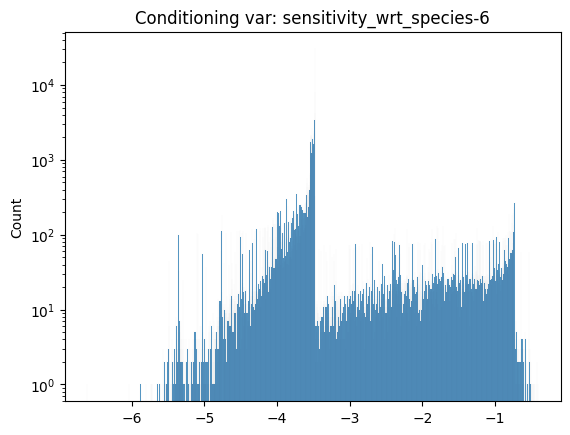

In [85]:
sns.histplot(cond.flatten(), log_scale=[False, True])
plt.title(f'Conditioning var: {target_circ_func}')

## Init model

In [86]:
enc_layers = [64] * NUM_ENC_LAYERS
dec_layers = [64] * NUM_DEC_LAYERS

def VAE_fn(enc_layers: list, dec_layers: list, call_kwargs: dict = {}):
    encoder = MLP(layer_sizes=enc_layers, n_head=dec_layers[0], use_categorical=False, name='encoder')
    decoder = MLP(layer_sizes=dec_layers, n_head=x.shape[-1], use_categorical=False, name='decoder')
    model = CVAE(encoder=encoder, decoder=decoder, embed_size=HIDDEN_SIZE)
    
    def init(x: np.ndarray, cond: np.ndarray, deterministic: bool):
        h = model.encoder(np.concatenate([x, cond], axis=-1))

        mu = model.h2mu(h)
        logvar = model.h2logvar(h)
        z = model.reparameterize(mu, logvar, hk.next_rng_key(), deterministic)
        z_cond = np.concatenate([z, cond], axis=-1)

        y = model.decoder(z_cond)
        return y
        
    return init, (encoder, decoder, model) #model(x, **call_kwargs)

model_fn = partial(VAE_fn, enc_layers=enc_layers, dec_layers=dec_layers)
# model = hk.transform(model_fn)
model_t = hk.multi_transform(model_fn)
params = model_t.init(rng, x, cond, deterministic=False)


/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/haiku/_src/initializers.py:126: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(
/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/haiku/_src/base.py:682: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


In [87]:
encoder, decoder, model = model_t.apply

In [88]:
h = encoder(params, rng, np.concatenate([x, cond], axis=-1))

In [89]:
model(params, rng, x, cond)

Array([[ 0.7371301 ,  0.44792718,  0.03250806,  0.17208868,  0.9457366 ,
         0.7565874 ],
       [ 1.1198169 ,  0.3690897 , -0.03259238,  0.32110068,  0.90995306,
         0.8642865 ],
       [ 1.2718142 ,  0.53434485,  0.03357688,  0.27734753,  0.53291905,
         1.3010721 ],
       ...,
       [ 0.77672416,  0.2856316 ,  0.14183122,  0.3700872 ,  0.7748682 ,
         0.885749  ],
       [ 1.0096142 ,  0.22104456,  0.10829021,  0.47092625,  0.9569979 ,
         1.1425644 ],
       [ 1.1020719 ,  0.53466976,  0.10361076,  0.23358177,  1.0017705 ,
         0.9300675 ]], dtype=float32)

## Init optimiser

In [90]:
optimiser = make_optimiser(LEARNING_RATE_SCHED, LEARNING_RATE,
                           EPOCHS, L2_REG_ALPHA, USE_WARMUP, WARMUP_EPOCHS, N_BATCHES)
optimiser_state = optimiser.init(x)

# Train

In [91]:
# [i_batch, Batches, *content]

x = x.reshape(N_BATCHES, BATCH_SIZE, x.shape[-1])
cond = cond.reshape(N_BATCHES, BATCH_SIZE, cond.shape[-1])
y = x.reshape(N_BATCHES, BATCH_SIZE, x.shape[-1])

x_train, cond_train, y_train = x[:int(TRAIN_SPLIT * N_BATCHES)], cond[:int(TRAIN_SPLIT * N_BATCHES)], y[:int(TRAIN_SPLIT * N_BATCHES)]
x_val, cond_val, y_val = x[int(TRAIN_SPLIT * N_BATCHES):], cond[int(TRAIN_SPLIT * N_BATCHES):], y[int(TRAIN_SPLIT * N_BATCHES):]

In [92]:
def train_step(params, x, y, cond, optimiser_state, model, rng, use_l2_reg, l2_reg_alpha, optimiser, loss_fn):

    loss, grads = jax.value_and_grad(loss_fn)(
        params, rng, model, x, y, use_l2_reg=use_l2_reg, l2_reg_alpha=l2_reg_alpha, cond=cond)

    updates, optimiser_state = optimiser.update(grads, optimiser_state)
    params = optax.apply_updates(params, updates)

    return params, optimiser_state, loss, grads


def eval_step(params, rng, model, x, y, cond, use_l2_reg, l2_reg_alpha, loss_fn, compute_accuracy):
    """ Return the average of loss and accuracy on validation data """
    loss = loss_fn(params, rng, model, x, y, use_l2_reg=use_l2_reg, l2_reg_alpha=l2_reg_alpha, cond=cond)
    pred_y = model(params, rng, x, cond=cond)
    acc = compute_accuracy(pred_y, y)
    return acc, loss


def run_batches(params, model, rng,
                x_batch, y_batch, cond_batch,
                use_l2_reg, l2_reg_alpha, optimiser, optimiser_state, loss_fn):

    f_train_step = partial(train_step, model=model, rng=rng,
                           use_l2_reg=use_l2_reg, l2_reg_alpha=l2_reg_alpha, optimiser=optimiser,
                           loss_fn=loss_fn)

    def f(carry, inp):

        params, optimiser_state = carry[0], carry[1]
        x_batch, y_batch, cond_batch = inp[0], inp[1], inp[2]

        params, optimiser_state, loss, grads = f_train_step(
            params, x_batch, y_batch, cond_batch, optimiser_state)
        return (params, optimiser_state), (loss, grads)

    # for x_batch, y_batch in xy_train:
    (params, optimiser_state), (train_loss, grads) = jax.lax.scan(
        f, (params, optimiser_state), (x_batch, y_batch, cond_batch))
    return params, optimiser_state, train_loss, grads


def train(params, rng, model,
          x_train, cond_train, y_train, x_val, cond_val, y_val,
          optimiser, optimiser_state,
          use_l2_reg, l2_reg_alpha, epochs,
          loss_fn, compute_accuracy,
          save_every, include_params_in_saves):

    def f(carry, _):
        params, optimiser_state = carry[0], carry[1]

        params, optimiser_state, train_loss, grads = run_batches(
            params, model, rng, x_train, y_train, cond_train, use_l2_reg, l2_reg_alpha, optimiser, optimiser_state, loss_fn)

        val_acc, val_loss = eval_step(
            params, rng, model, x_val, y_val, cond_val, use_l2_reg, l2_reg_alpha, loss_fn, compute_accuracy)

        return (params, optimiser_state), (params, grads, train_loss, val_loss, val_acc)

    saves = {}
    for e in range(epochs):
        (params, optimiser_state), (params_stack, grads, train_loss,
                                    val_loss, val_acc) = f((params, optimiser_state), None)

        if np.mod(e, save_every) == 0:
            saves[e] = make_saves(
                train_loss, val_loss, val_acc, include_params_in_saves, params_stack, grads)
            print(
                f'Epoch {e} / {epochs} -\t\t Train loss: {np.mean(train_loss)}\tVal loss: {val_loss}\tVal accuracy: {val_acc}')

    saves[list(saves.keys())[-1]]['params'] = params
    return params, saves

In [93]:
params, saves = train(params, rng, model, 
                      x_train, cond_train, y_train, x_val, cond_val, y_val, 
                      optimiser, optimiser_state,
                      use_l2_reg=USE_L2_REG, l2_reg_alpha=L2_REG_ALPHA, epochs=EPOCHS,
                      loss_fn=loss_fn, compute_accuracy=accuracy_regression,
                      save_every=PRINT_EVERY, include_params_in_saves=False) 

Epoch 0 / 1000 -		 Train loss: 19.198318481445312	Val loss: 18.089309692382812	Val accuracy: 0.17625868320465088
Epoch 10 / 1000 -		 Train loss: 12.727226257324219	Val loss: 12.50259780883789	Val accuracy: 0.0029079862870275974
Epoch 20 / 1000 -		 Train loss: 3.600236177444458	Val loss: 3.4090983867645264	Val accuracy: 0.08836263418197632
Epoch 30 / 1000 -		 Train loss: 1.1733393669128418	Val loss: 1.0789339542388916	Val accuracy: 0.16496853530406952
Epoch 40 / 1000 -		 Train loss: 0.3445998728275299	Val loss: 0.32608267664909363	Val accuracy: 0.3717719316482544
Epoch 50 / 1000 -		 Train loss: 0.22356657683849335	Val loss: 0.2161404937505722	Val accuracy: 0.4348036050796509
Epoch 60 / 1000 -		 Train loss: 0.1763131320476532	Val loss: 0.1703469455242157	Val accuracy: 0.48515626788139343
Epoch 70 / 1000 -		 Train loss: 0.1484338790178299	Val loss: 0.1432100087404251	Val accuracy: 0.5272732377052307
Epoch 80 / 1000 -		 Train loss: 0.12937429547309875	Val loss: 0.12443465739488602	Val accu

# Visualise

Text(0.5, 0, 'step')

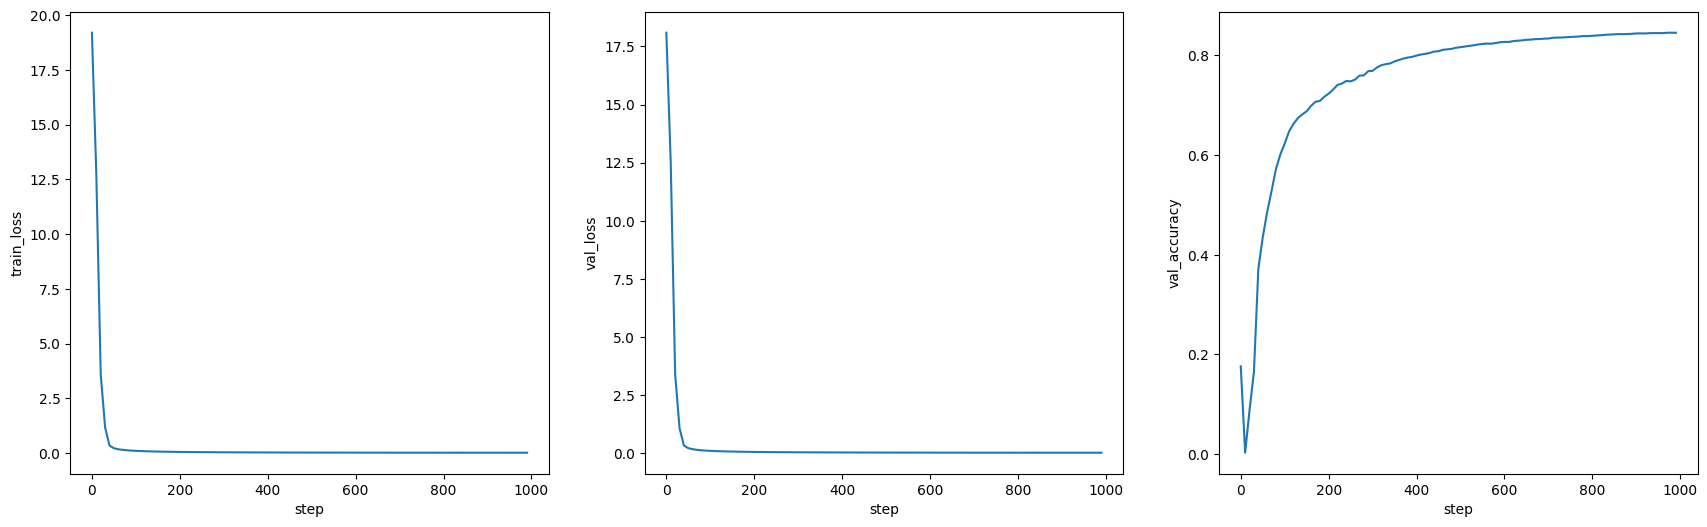

In [94]:
plt.figure(figsize=(7*3, 6))
ax = plt.subplot(1, 3, 1)
plt.plot(list(saves.keys()), [v['train_loss'] for v in saves.values()])
plt.ylabel('train_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 2)
plt.plot(list(saves.keys()), [v['val_loss'] for v in saves.values()])
plt.ylabel('val_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 3)
plt.plot(list(saves.keys()), [v['val_accuracy'] for v in saves.values()])
plt.ylabel('val_accuracy')
plt.xlabel('step')

In [95]:
write_json(saves, out_path=save_path)

In [96]:
print(save_path)

weight_saves/10_cvae/2023_12_14__11_37_03_saves_test


# Examine trained model

In [97]:
fn_saves = os.path.join('weight_saves', '10_cvae', '2023_12_14__10_42_07_saves_test')
fn_saves = save_path
saves_loaded = load_json_as_dict(fn_saves)

p = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
p = arrayise(p)
# p['vae/~/h2mu'] = p.pop('vae/~/linear')
# p['vae/~/h2logvar'] = p.pop('vae/~/linear_1')

pred_y = model(p, rng, x, cond)
pred_y.shape

(1200, 128, 6)

The R2 score is  0.9986399956734262
The R2 score with weighted variance is  0.9986399956734262


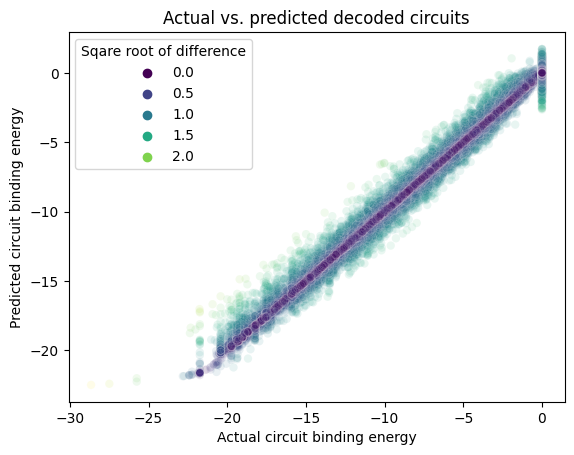

In [98]:
g = sns.scatterplot(x=y.flatten(), y=pred_y.flatten(), alpha=0.1, hue=np.sqrt(np.abs(pred_y.flatten() - y.flatten())), palette='viridis')
g.legend_.set_title('Sqare root of difference')
plt.title(f'Actual vs. predicted decoded circuits')
plt.xlabel('Actual circuit binding energy')
plt.ylabel('Predicted circuit binding energy')
# plt.legend(title='')

print('The R2 score is ', r2_score(y.flatten(), pred_y.flatten()))
print('The R2 score with weighted variance is ', r2_score(
    y.flatten(), pred_y.flatten(), multioutput='variance_weighted'))

# Sample fake circuits

In [145]:
n_to_sample = 10000

sampled_cond = np.interp(np.random.rand(n_to_sample, cond.shape[-1]), [0, 1], [cond.min(), cond.max()])
mu = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 5000
logvar = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 100
z = sample_z(mu=mu, logvar=logvar, key=rng)
z = np.concatenate([z, sampled_cond], axis=-1)

fake_circuits = decoder(p, rng, z)
fake_circuits = np.where(fake_circuits > 0, 0, fake_circuits)
sampled_cond.shape

(10000, 1)

Text(0.5, 0.98, 'CVAE: 10000 circuits')

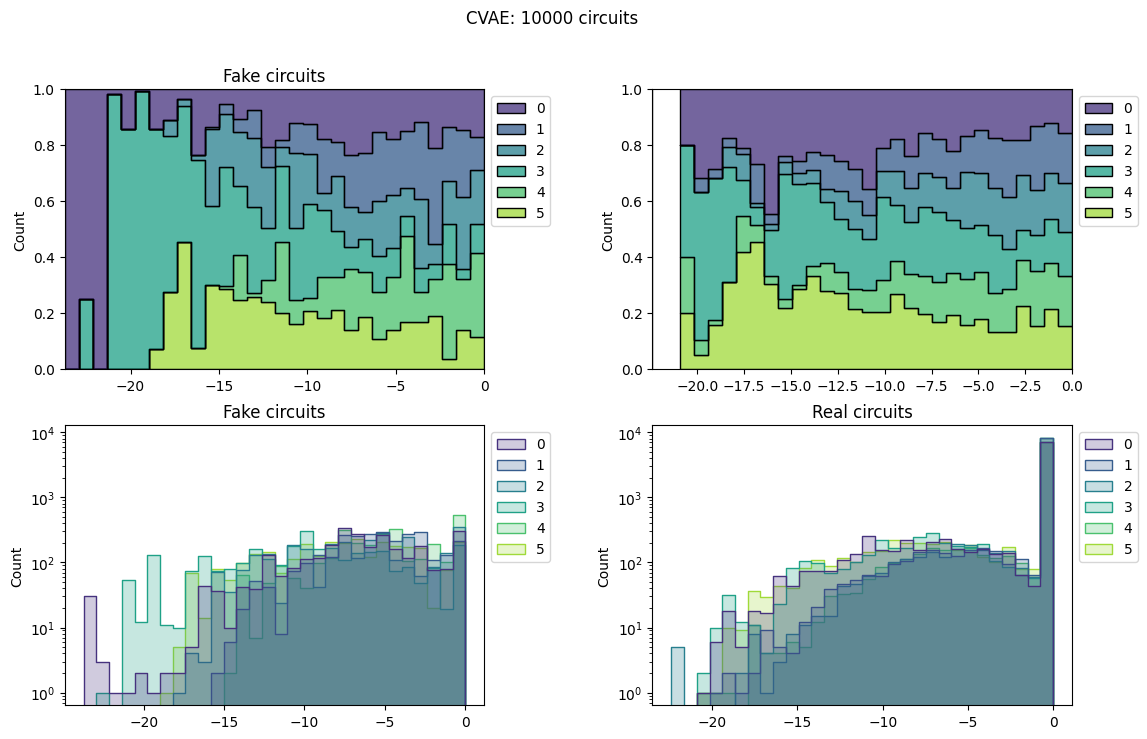

In [136]:
fig = plt.figure(figsize=(13, 8))
fig.subplots_adjust(wspace=0.4)

ax = plt.subplot(2,2,1)
g = sns.histplot(fake_circuits, element='step', bins=30, palette='viridis', multiple='fill')
plt.title('Fake circuits')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2,2,2)
g = sns.histplot(x.reshape(np.prod(x.shape[:-1]), x.shape[-1])[:n_to_sample], 
             element='step', bins=30, palette='viridis', multiple='fill')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2,2,3)
g = sns.histplot(fake_circuits, element='step', bins=30, palette='viridis', multiple='layer', fill=True, log_scale=[False, True])
plt.title('Fake circuits')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2,2,4)
g2 = sns.histplot(x.reshape(np.prod(x.shape[:-1]), x.shape[-1])[:n_to_sample], 
             element='step', bins=30, palette='viridis', multiple='layer', fill=True, log_scale=[False, True])
plt.title('Real circuits')
sns.move_legend(g2, 'upper left', bbox_to_anchor=(1, 1))

g.set_ylim(g2.get_ylim())

plt.suptitle(f'CVAE: {n_to_sample} circuits')

Text(0.5, 0.98, 'CVAE: 300 circuits')

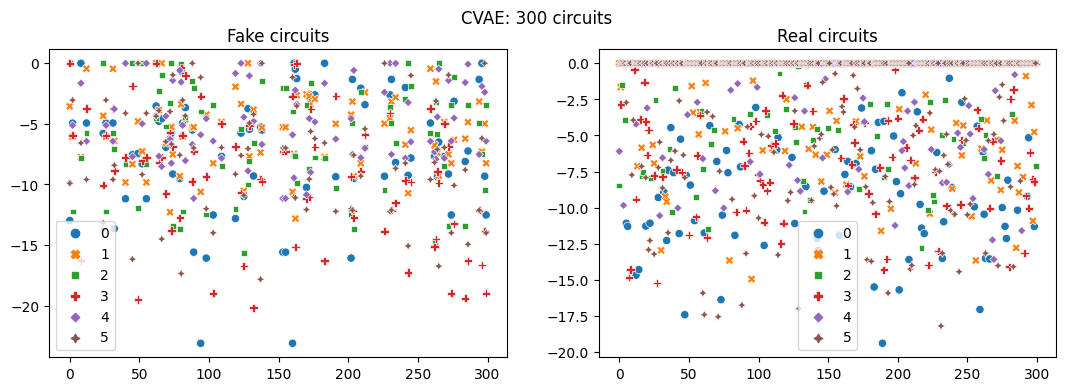

In [137]:
fig = plt.figure(figsize=(13, 4))

show_max = 300

ax = plt.subplot(1,2,1)
sns.scatterplot(fake_circuits[:show_max])
plt.title('Fake circuits')

ax = plt.subplot(1,2,2)
sns.scatterplot(x.reshape(np.prod(x.shape[:-1]), x.shape[-1])[:show_max])
plt.title('Real circuits')

plt.suptitle(f'CVAE: {show_max} circuits')

## Conditionality

In [167]:
n_categories = 10
n_to_sample = 10000

sampled_cond = np.repeat(np.linspace(cond.min(), cond.max(), n_categories)[:, None], repeats=n_to_sample, axis=1)[:, :, None]
mu = np.random.normal(size=(n_to_sample, HIDDEN_SIZE))
logvar = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 10
z = sample_z(mu=mu, logvar=logvar, key=rng)
z = np.repeat(z[None, :], repeats=n_categories, axis=0)
z = np.concatenate([z, sampled_cond], axis=-1)

fake_circuits = jax.vmap(partial(decoder, params=p, rng=rng))(x=z)
fake_circuits = np.where(fake_circuits > 0, 0, fake_circuits)

In [168]:
fig = plt.figure(figsize=(10*2, 5*5))
show_max = 300
for i, cat in enumerate(fake_circuits):
    ax = plt.subplot(5, 2, i+1)
    sns.scatterplot(cat[:show_max])
    plt.title('Fake circuit: ')

plt.suptitle(f'CVAE: {show_max} circuits')

(10, 10000, 6)

In [166]:
sampled_cond.shape

(10, 10000, 1)